## Inspect data

In [57]:
import json
from constants import TEXTS_DIR, PERSPECTIVE_API_RESPONSE_DIR

In [ ]:
# Print sample text
sample_text_file = TEXTS_DIR / '0000108-c17b018a21dba0c9c84e5f6dca782cbd.txt'
sample_text_file.read_text()

In [ ]:
# Print sample response
sample_response_file = PERSPECTIVE_API_RESPONSE_DIR / '0000108-c17b018a21dba0c9c84e5f6dca782cbd.txt.json'

with sample_response_file.open() as f:
    sample_response = json.load(f)

sample_response

## Load into pandas

In [ ]:
%matplotlib inline
import pandas as pd
from pathlib import Path
import os
from constants import TOXICITY_SCORES_PICKLE

In [38]:
# Load Perspective API responses into dataframe

if not TOXICITY_SCORES_PICKLE.exists():
    rows = []

    for toxicity_file in PERSPECTIVE_API_RESPONSE_DIR.iterdir():
        if toxicity_file.suffix != '.json':
            continue

        toxicity_json = json.load(toxicity_file.open())
        toxicity_score = toxicity_json['attributeScores']['TOXICITY']['summaryScore']['value']

        text_filename = toxicity_file.name[:-5]
        assert text_filename.endswith('.txt')
        text_file = TEXTS_DIR / text_filename
        text = text_file.read_text()

        rows.append([text_filename, toxicity_score, text])

    df = pd.DataFrame(rows, columns=['filename', 'toxicity_score', 'text'])
    
    # Save a pickle for later
    df.to_pickle(TOXICITY_SCORES_PICKLE)
else:
    df = pd.read_pickle(TOXICITY_SCORES_PICKLE)

## Basic Analysis

In [40]:
# Data sorted by toxicity
df.sort_values(by=['toxicity_score'], ascending=False).reset_index()

,index,filename,toxicity_score,text
0,123084,0490610-99f159c7a4b9868addbda9199cb17cdf.txt,0.990670,"FUCK /u/SPEZ , YOU FUCKING WORTHLESS CUCK FUCK..."
1,85098,0672031-2e34d061fc3c5e59d8730115bf3ef6b5.txt,0.947267,From fucking fbombingmom:\n\nI’d like to submi...
2,85265,0015608-1d7d2627e8be693ee345f6c5a4a79786.txt,0.946782,"'No, Really, Fuck Every One Of You'\n\nWASHING..."
3,54476,0278354-b3bdb61b43e24d62f7a1cbc88c41598c.txt,0.946288,Air America's Randi Rhodes said suspended for ...
4,29478,0005265-30f6c1242730bf4f9ef4ac0a65b785a7.txt,0.927032,"Jang Moonbok, the “fuckboy” from ‘God Of Music..."
5,18701,0764561-709f4ecb3166356dd57ecac7e266f858.txt,0.921134,You probably heard about the deranged sorority...
6,57452,0027620-b27d673c1fb056b708559632f7f0ca9b.txt,0.907830,Evan Brunell is a baseball writer and the pres...
7,44406,0092718-0b244361bde2506bb51478de5777712b.txt,0.899773,\n\nDoes your vagina have a brand?\n\nLet your...
8,4740,0159720-0dffc558696a5a22303ef62e0faa1f83.txt,0.899565,feminismisimportantlove:\n\ndanny-dice:\n\nfem...
9,95491,0955335-decce7189212838edb4fae8130e9977e.txt,0.899428,Login to vote this up!\n\nSo my brother just l...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8d8f79208>]],
      dtype=object)

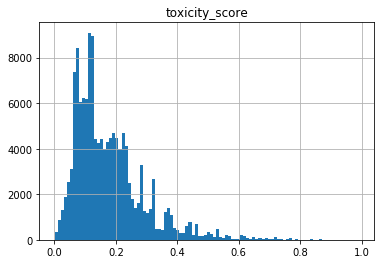

In [64]:
# Histogram of toxicity scores
df.hist(column='toxicity_score', bins=100)

## Analyze with NLTK

In [ ]:
from collections import Counter
import nltk
from nltk import ngrams

In [43]:
all_texts = list(sorted_df['text'])

In [44]:
# Calculate n-gram frequencies
N = 2
limit = 1000

freqs = Counter()
for text in all_texts[:limit]:
    freqs += Counter(ngrams(text.split(' '), n=N))

In [45]:
# Show most common n-grams
freqs.most_common(100)

[(('of', 'the'), 2650),
 (('in', 'the'), 2356),
 (('to', 'the'), 1392),
 (('to', 'be'), 1253),
 (('on', 'the'), 1226),
 (('in', 'a'), 875),
 (('I', 'was'), 810),
 (('is', 'a'), 781),
 (('for', 'the'), 762),
 (('and', 'the'), 728),
 (('at', 'the'), 716),
 (('of', 'a'), 682),
 (('with', 'a'), 674),
 (('going', 'to'), 664),
 (('with', 'the'), 649),
 (('out', 'of'), 628),
 (('want', 'to'), 613),
 (('and', 'I'), 557),
 (('from', 'the'), 538),
 (('as', 'a'), 532),
 (('it', 'was'), 526),
 (('for', 'a'), 525),
 (('is', 'the'), 495),
 (('to', 'get'), 484),
 (('have', 'to'), 483),
 (('one', 'of'), 472),
 (('was', 'a'), 468),
 (('to', 'a'), 466),
 (('that', 'the'), 432),
 (('to', 'do'), 420),
 (('I', 'have'), 399),
 (('that', 'I'), 397),
 (('if', 'you'), 394),
 (('have', 'a'), 390),
 (('by', 'the'), 388),
 (('about', 'the'), 383),
 (('all', 'the'), 368),
 (('and', 'a'), 368),
 (('trying', 'to'), 365),
 (('like', 'a'), 362),
 (('he', 'was'), 360),
 (('of', 'my'), 353),
 (('a', 'lot'), 352),
 (('of

In [ ]:
# TODO: show n-grams that are *unique* to high-toxicity text